## CostlyConversion

### Jessica Peck, October 26, 2018

You sit inside the product team at Symantec, which sells a cyber security software for $\$39$ across a variety of devices. Revenue has been flat for some time, so the VP of Product would like to experiment with the effect of increasing the price. Your team designed an experiment to measure the effect of doing so. 

In the experiment, 66% of the users have seen the old price ($\$39$), while a random sample of 33% users were shown a higher price ($\$59$).

The experiment has been running for some time and the VP of Product is interested in understanding how it went. She would like to learn key insights about what drives conversion rate. She'd like a recommendation of what price to sell the software at, and for you to quantify the cost of the experiment and whether you could have done it in shorter time. Would you have designed the experiment differently, why or why not?




# Goals
What drives the conversion rate?

What price to sell the software at?

How much did the experiment cost?

Could it be done in a shorter time?

How would you have designed the experiment differently? 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

import geopandas
from shapely.geometry import Point
import matplotlib.pylab as plt
from pylab import rcParams

import missingno
import statsmodels.api as sm



#from sklearn import preprocessing
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import train_test_split
#from sklearn import metrics

%pylab inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth',500)    

Populating the interactive namespace from numpy and matplotlib


## Test Results Table

user_id : Id of the user. Matches user_id in user_table

timestamp : the date and time when the user first accesed the company sales website (user local time)

source : marketing channel that generated the user's site visit:  ads-["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google ads, yahoo ads, etc. seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google search, yahoo, facebook, etc.

friend_referral : user coming from a referral link of another user

direct_traffic: user coming by directly typing the address of the site on the browser

device : user device. Can be mobile or web

operative_system : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile. "Other" if it is none of the above

test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old, lower price)

price : the price the user sees. It should match test

converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).

In [2]:
# read in data
testresults = pd.read_csv('../test_results.csv')

In [3]:
# check format
testresults.head(3)

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0


In [4]:
testresults.describe()

,Unnamed: 0,user_id,test,price,converted
count,316800.000000,316800.000000,316800.000000,3.168000e+05,316800.000000
mean,158399.500000,499281.341840,0.360079,6.457590e+06,0.018333
std,91452.426977,288591.154044,0.480024,6.797307e+07,0.134154
min,0.000000,3.000000,0.000000,3.900000e+01,0.000000
25%,79199.750000,249525.750000,0.000000,3.900000e+01,0.000000
50%,158399.500000,499021.500000,0.000000,3.900000e+01,0.000000
75%,237599.250000,749025.500000,1.000000,5.900000e+01,0.000000
max,316799.000000,1000000.000000,1.000000,9.998843e+08,1.000000


In [5]:
# no values besides 0/1 in the test indicator
testresults['test'].value_counts()

0    202727
1    114073
Name: test, dtype: int64

In [6]:
# no values besides 0/1 in the converted indicator
testresults['converted'].value_counts()

0    310992
1      5808
Name: converted, dtype: int64

In [7]:
# Price distribution looks odd. Turns out there are ~ 3000 weird large-number prices (like 536537851.0) that customers were shown.
testresults['price'].describe()

count    3.168000e+05
mean     6.457590e+06
std      6.797307e+07
min      3.900000e+01
25%      3.900000e+01
50%      3.900000e+01
75%      5.900000e+01
max      9.998843e+08
Name: price, dtype: float64

In the price variable, there are about 3000 large-value "mistake" prices (?) outo of about 300k (potentially) real data.
It's not clear why these numbers were shown to customers, but they should be omitted from the results.
Not clear whether a "wrong" price is only shown to our side and "real" value could be imputed?

In [8]:
# how many test results total?
len(testresults)

316800

In [9]:
# Total count of 39 or 59 records minus count of weird-number records
sum(testresults['price'].value_counts().iloc[0:2]) - sum(testresults['price'].value_counts().iloc[3:])

310653

In [10]:
testresults['price'].value_counts().head(5)

39.0           200747
59.0           112979
536537851.0         1
722005503.0         1
362003840.0         1
Name: price, dtype: int64

In [11]:
# anything jump out about the weird-price sample? 
testresults[testresults['price'] > 100].describe()

,Unnamed: 0,user_id,test,price,converted
count,3074.000000,3074.000000,3074.000000,3.074000e+03,3074.000000
mean,157564.235198,496257.819128,0.373780,6.655010e+08,0.019193
std,91677.315621,286851.064251,0.483885,1.938532e+08,0.137226
min,94.000000,112.000000,0.000000,3.246805e+08,0.000000
25%,77694.250000,254223.500000,0.000000,4.997930e+08,0.000000
50%,157247.500000,485644.500000,0.000000,6.685073e+08,0.000000
75%,235591.750000,741266.250000,1.000000,8.298946e+08,0.000000
max,316386.000000,999743.000000,1.000000,9.998843e+08,1.000000


If those weird-price customers were actually shown that price:
1. looks like almost none of them converted
2. looks like all of them were in the "treatment" group,
(or maybe the test variable was generated mechanically as > 39 from the price column)

In [12]:
# count converted values w/i weird price sample
# count treatment group indicator w/i weird price sample
print(testresults[testresults['price'] > 100]['converted'].value_counts(), testresults[testresults['price'] > 100]['test'].value_counts())

0    3015
1      59
Name: converted, dtype: int64 0    1925
1    1149
Name: test, dtype: int64


In [13]:
# Check Id's are unique (not dupes)
print(len((testresults['user_id']).unique()), len(testresults))

316800 316800


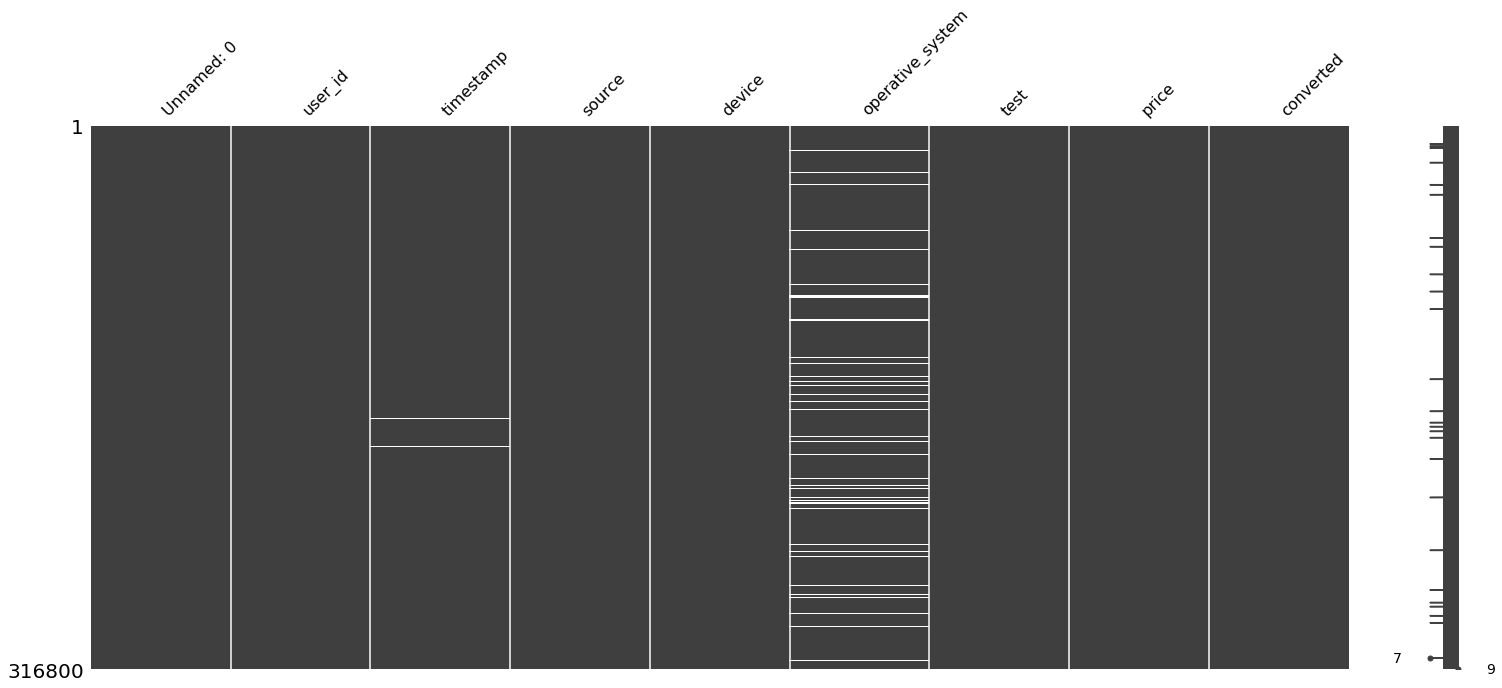

In [14]:
# Check for missing values
missingno.matrix(testresults)

In [15]:
testresults.operative_system.value_counts()

windows    100878
iOS         95352
android     74856
mac         25056
i0S           113
wnddows        98
anroid         79
apple          29
Name: operative_system, dtype: int64

## User Table


city: city name string

country: country name string

lat/long: geographic coordinates

In [16]:
usertable = pd.read_csv('../user_table.csv')

In [17]:
usertable.head(3)

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39


In [18]:
usertable.describe()

,user_id,lat,long
count,275616.000000,275616.000000,275616.000000
mean,499245.801521,37.111680,-93.981772
std,288533.458944,5.209627,18.086486
min,3.000000,19.700000,-157.800000
25%,249544.500000,33.660000,-112.200000
50%,498861.000000,37.740000,-88.930000
75%,748856.500000,40.700000,-78.910000
max,999999.000000,61.180000,30.310000


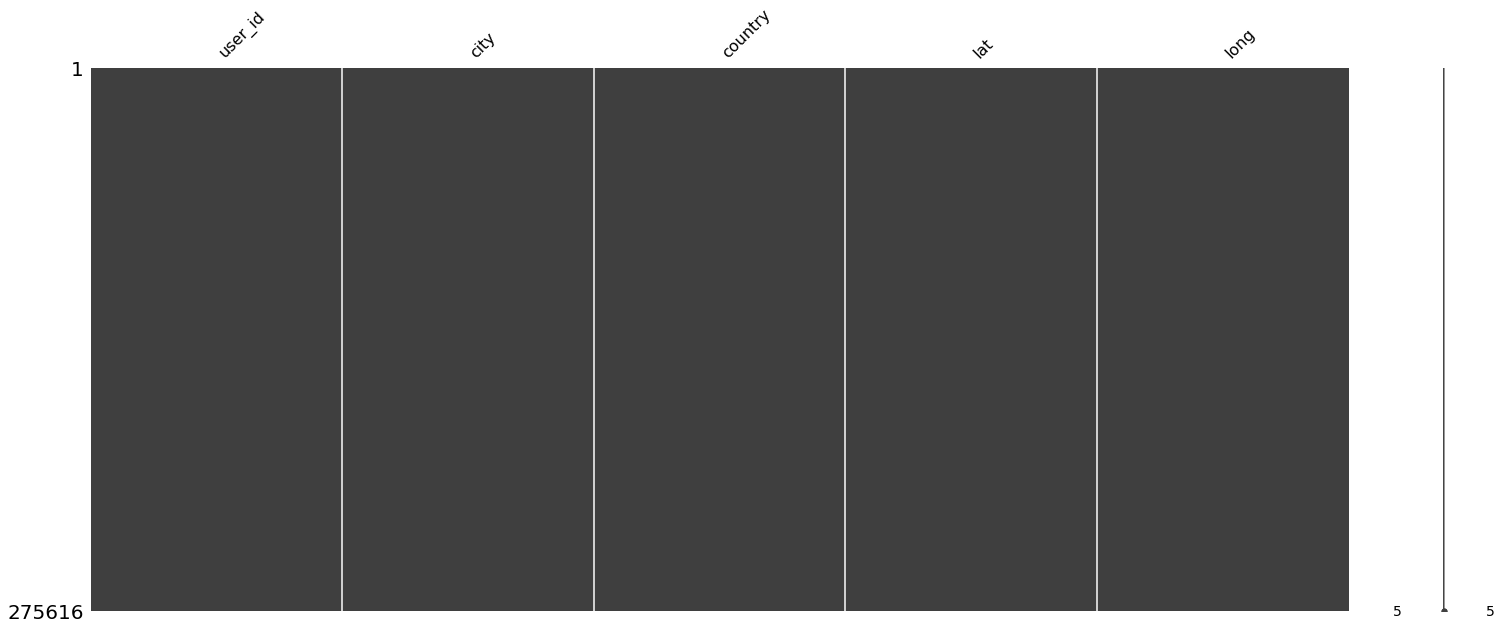

In [19]:
missingno.matrix(usertable)

In [20]:
# merge testresults and user table son user_id

newdf = pd.merge(testresults, usertable, on='user_id')

In [21]:
len(usertable)

275616

In [22]:
len(testresults)

316800

In [23]:
len(newdf)

275616

In [24]:
newdf.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02


## Using the location data
The country variable says all users are USA based. 
Does that mean the design of the experiment was to target US users? 

From the map below, clearly there's a mismatch between country and location data in this table.
Is the location-grabber function in our pipeline broken?
Is it fraud or malicious action? (Hey aren't we a computer security company?)

In [25]:
newdf.country.value_counts()

USA    275616
Name: country, dtype: int64

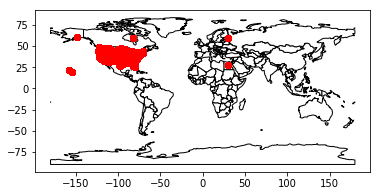

In [26]:
newdf['coordinates'] =  list(zip(newdf.long, newdf.lat))
newdf['coordinates'] = newdf['coordinates'].apply(Point)

gdf = geopandas.GeoDataFrame(newdf, geometry='coordinates')

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot( color='white', edgecolor='black')

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, color='red')
#plt.show()
#plt.savefig('map.png', dpi=400)

In [28]:
# we have some points off to the west that appear to be in the US
newdf[(newdf['long'] < -125)].city.value_counts()

Anchorage    522
Honolulu     352
Hilo          18
Name: city, dtype: int64

## Some of our users for this test are in St Petersburg (Russia? Florida?)
There are three extra copies of St Petersburg. 
One is in Floria, the others are in Asia, Africa, and Northern Canada. 
It's unclear whether these were all supposed to be in the US or if there are Russian users mixed in. 

If I had more time, I might attempt to include the non-US data points and figure out which are which.
Until then, I think it's a cleaner experiment if it doesn't cross international borders, so I'm dropping them.

In [29]:
newdf.columns

Index(['Unnamed: 0', 'user_id', 'timestamp', 'source', 'device',
       'operative_system', 'test', 'price', 'converted', 'city', 'country',
       'lat', 'long', 'coordinates'],
      dtype='object')

In [30]:
# counts for the extra St. Petersburg entries
newdf[(newdf['lat'] > 53) & (newdf['long'] > 25)].city.value_counts()

Saint Petersburg    192
Name: city, dtype: int64

In [31]:
wrongrussia = newdf[(newdf['lat'] > 53) & (newdf['long'] > 25)]

In [32]:
wrongrussia.test.value_counts()

0    100
1     92
Name: test, dtype: int64

In [33]:
wrongrussia.price.value_counts()

39.0           100
59.0            90
958639538.0      1
604157977.0      1
Name: price, dtype: int64

In [34]:
wrongrussia.converted.value_counts()

0    190
1      2
Name: converted, dtype: int64

In [35]:
wrongrussia.source.value_counts()

ads-google         41
ads_facebook       32
ads_other          20
direct_traffic     20
friend_referral    20
seo-other          13
seo-google         13
seo_facebook       12
ads-yahoo          11
ads-bing            6
seo-yahoo           3
seo-bing            1
Name: source, dtype: int64

In [36]:
wrongrussia.device.value_counts()

mobile    102
web        90
Name: device, dtype: int64

In [37]:
wrongrussia.operative_system.value_counts()

windows    60
iOS        58
android    37
mac        22
Name: operative_system, dtype: int64

In [38]:
# remove non-US-location st petersburg user data
# constrain to south of latitude 53
newdf = newdf[newdf['lat'] < 53]
# constrain to east of longitude -100
newdf = newdf[newdf['long'] < 25]

In [39]:
# that doesn't fix the problem with the prices, so drop price >100 too.
newdf.price.value_counts().head()

39.0           174053
59.0            97846
536537851.0         1
721845395.0         1
362003840.0         1
Name: price, dtype: int64

In [40]:
newdf = newdf[newdf['price'] < 100]

## NANs for 'operative_system', 'source', and 'timestamp'

operative_system and source can get a new categorical variable and maybe still be useful.

Timestamp (if I include it in a regression) may cause trouble. Will drop.

### Timestamp

In [41]:
newdf[pd.isna(newdf['timestamp'])].test.value_counts()

0    179
1    111
Name: test, dtype: int64

In [42]:
len(newdf)

271899

In [43]:
len(newdf[pd.notnull(newdf['timestamp'])])

271609

In [44]:
newdf = newdf[pd.notnull(newdf['timestamp'])]

### Source

In [45]:
newdf[pd.isna(newdf['source'])].test.value_counts()

0    170
1     98
Name: test, dtype: int64

In [46]:
len(newdf[pd.isna(newdf['source'])])

268

In [196]:
# new category: unknown
newdf['source'] = newdf['source'].fillna('unknown')

In [77]:
newdf['source'].unique()

array(['ads_facebook', 'seo-google', 'ads-bing', 'direct_traffic',
       'ads-google', 'friend_referral', 'ads_other', 'ads-yahoo',
       'seo-yahoo', 'seo_facebook', 'seo-bing', 'seo-other', 'unknown'],
      dtype=object)

### Operative System

In [48]:
newdf[pd.isna(newdf['operative_system'])].test.value_counts()

0    10971
1     6517
Name: test, dtype: int64

In [49]:
len(newdf[pd.isna(newdf['operative_system'])])

17488

In [50]:
newdf['operative_system'] = newdf['operative_system'].fillna('unknown')

In [76]:
# there are a bunch of typos and repeats to clean
newdf['operative_system'].unique()

array(['iOS', 'android', 'mac', 'windows', 'unknown'], dtype=object)

In [69]:
newdf['operative_system'] = np.where(newdf['operative_system'] == 'wnddows', 'windows', newdf['operative_system'])

In [71]:
newdf['operative_system'] = np.where(newdf['operative_system'] == 'i0S', 'iOS', newdf['operative_system'])

In [73]:
newdf['operative_system'] = np.where(newdf['operative_system'] == 'anroid', 'android', newdf['operative_system'])

In [75]:
newdf['operative_system'] = np.where(newdf['operative_system'] == 'apple', 'mac', newdf['operative_system'])

### What can I say about the distributions in this dataframe? Can I show that my A and B groups are the same?

In [78]:
newdf.columns

Index(['Unnamed: 0', 'user_id', 'timestamp', 'source', 'device',
       'operative_system', 'test', 'price', 'converted', 'city', 'country',
       'lat', 'long', 'coordinates', 'testdate', 'date'],
      dtype='object')

In [79]:
# what are the datatypes?
for thing in newdf.columns:
    print( type(newdf[thing][0]), thing)

<class 'numpy.int64'> Unnamed: 0
<class 'numpy.int64'> user_id
<class 'str'> timestamp
<class 'str'> source
<class 'str'> device
<class 'str'> operative_system
<class 'numpy.int64'> test
<class 'numpy.float64'> price
<class 'numpy.int64'> converted
<class 'str'> city
<class 'str'> country
<class 'numpy.float64'> lat
<class 'numpy.float64'> long
<class 'shapely.geometry.point.Point'> coordinates
<class 'pandas._libs.tslibs.timestamps.Timestamp'> testdate
<class 'str'> date


In [80]:
# need to convert timestamp to datetime object for plotting
newdf.timestamp[0]

'2015-05-08 03:38:34'

In [83]:
# coerce timestamp to datetime object
newdf['date'] = [x.split()[0] for x in newdf['timestamp']]
newdf['testdate'] = pd.to_datetime(newdf['date'], errors='coerce')
newdf['testdate'] = pd.to_datetime(np.where(pd.isna(newdf['testdate']), newdf['date'].str.replace('2815', '2015'), newdf['testdate']))

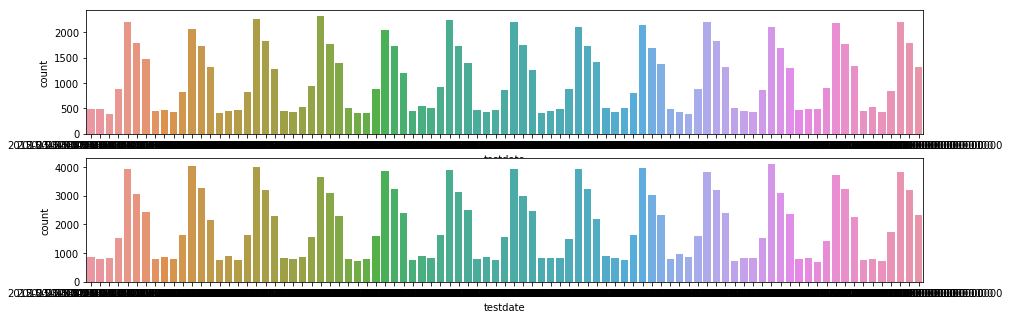

In [84]:
rcParams['figure.figsize'] = 15, 5

# Plot counts over time
# Pretty big weekly cyclicality. People like to buy on weekends?
fig, ax =plt.subplots(2,1)
sns.countplot(newdf[newdf['test']==1]['testdate'], ax=ax[0])
sns.countplot(newdf[newdf['test']==0]['testdate'], ax=ax[1])



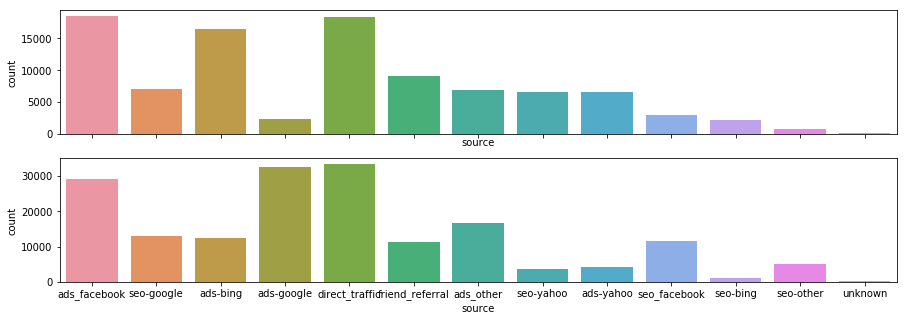

In [87]:
# Web traffic source
fig, ax =plt.subplots(2,1, sharex=True)
sns.countplot(newdf[newdf['test']==1]['source'], ax=ax[0])
sns.countplot(newdf[newdf['test']==0]['source'], ax=ax[1])




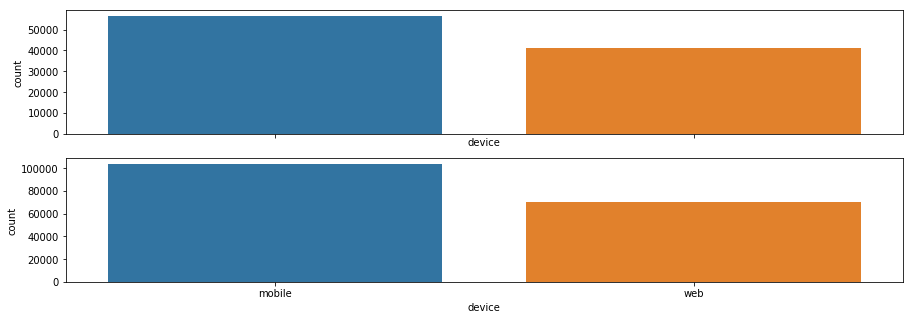

In [88]:
# web vs desktop device label
rcParams['figure.figsize'] = 15, 5

fig, ax =plt.subplots(2,1, sharex = True)
sns.countplot(newdf[newdf['test']==1]['device'], ax=ax[0])
sns.countplot(newdf[newdf['test']==0]['device'], ax=ax[1])


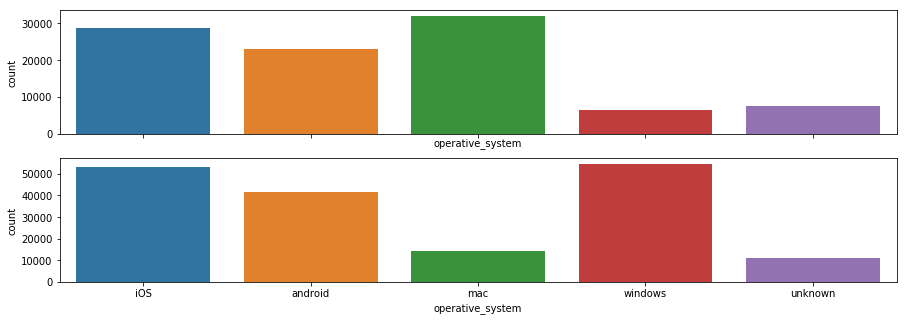

In [89]:
# operating sytem: way more mac people in the treated group, more windows people in the control group.
# I wonder if there's a way to condition what price we show on their operating system? This coudl be better balanced
fig, ax =plt.subplots(2,1, sharex = True)
sns.countplot(newdf[newdf['test']==1]['operative_system'], ax=ax[0])
sns.countplot(newdf[newdf['test']==0]['operative_system'], ax=ax[1])

In [90]:
# how many unique data-collection dates do we have?
len(newdf.testdate.unique())*2

182

In [91]:
# plot conversion rate over time?

plotdf = newdf[['test','testdate', 'converted']]
sums = plotdf.set_index('testdate').groupby(['test', pd.Grouper(freq='D')])['converted'].sum()
counts =  plotdf.set_index('testdate').groupby(['test', pd.Grouper(freq='D')])['converted'].count()

In [92]:
len(plotdf)

271609

In [93]:
sums = sums.reset_index(level=0)
counts = counts.reset_index(level=0)

In [94]:
sumspivot = sums.pivot(columns = 'test', values = 'converted')
countspivot = counts.pivot(columns = 'test', values = 'converted')

In [95]:
sumspivot.head(2)

test,0,1
testdate,,
2015-03-02,15,8
2015-03-03,19,4


In [96]:
countspivot.head(2)

test,0,1
testdate,,
2015-03-02,867,492
2015-03-03,802,494


In [97]:
rates = sumspivot/countspivot

In [98]:
rates.columns = ['control', 'treated']

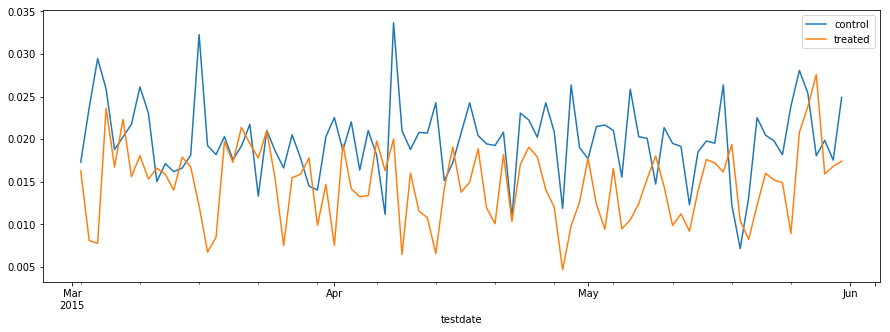

In [99]:
# daily conversion rate (#conversions / total impressions per day by test group) 
rates.plot()

In [100]:
cumulative_rates = sumspivot.cumsum() / countspivot.cumsum()


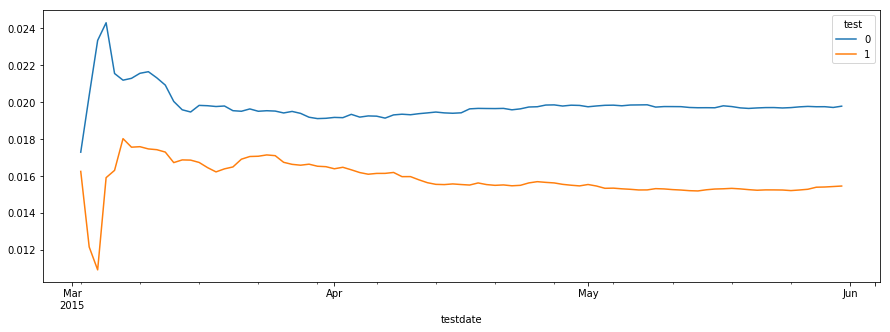

In [101]:
# cumulative conversion rate (all previous elapsed conversion / all elapsed impressions by test group )
cumulative_rates.plot()

In [133]:
prices = pd.Series({'control': 39, 'treated': 59})

In [135]:
cumulative_rates.columns = ['control', 'treated']

In [137]:
vpc = cumulative_rates * prices

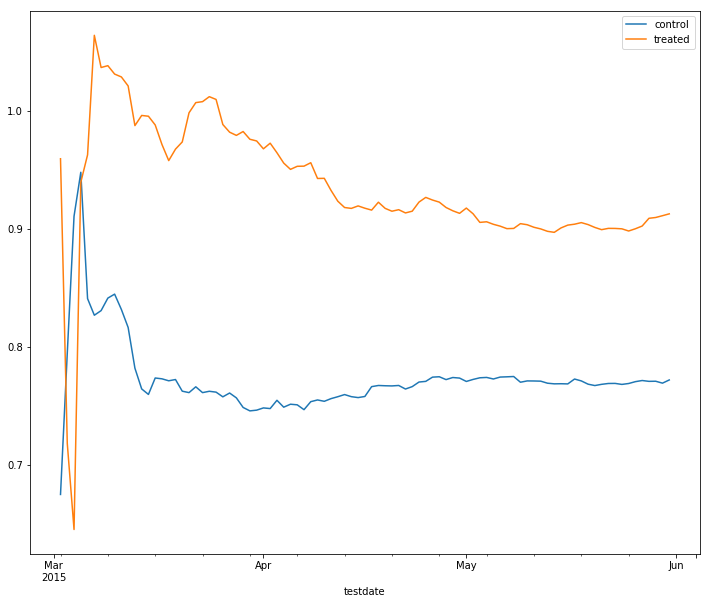

In [139]:
# Cumulative Rate * Price gives value per impression for each group
vpc.plot()

## How do I calculate how much this experiment "cost" me (or in this case, made me money)?

In [156]:
# control dollars per impression for control price * total count treated impressions
# opportunity cost (you could have shown all the $59 people $39 instead and had this)
opcost = vpc.tail(1).iloc[0,0] * countspivot.sum()[1]
opcost

75392.8139208629

In [157]:
# control dollars per impression for treated price * total count treated impressions
# what we actually got from treated group
treatedrevenue = vpc.tail(1).iloc[0,1] * countspivot.sum()[1]
treatedrevenue

89149.0

In [158]:
# we made ~ $13K off this
treatedrevenue-opcost

13756.1860791371

## What variables drive the conversion rate? Try regression for inference.


In [ ]:
# there's some strong weekly cyclicality, so best put in dummies for weekdays
newdf['weekday'] = [x.weekday() for x in newdf['testdate']]

In [114]:
# convert all relevant features to dummies
daysofweek = pd.get_dummies(newdf['weekday'],drop_first=True)
source = pd.get_dummies(newdf['source'],drop_first=True)
opsystem = pd.get_dummies(newdf['operative_system'],drop_first=True)
device = pd.get_dummies(newdf['device'],drop_first=True)
test = newdf['test']

fitdf = pd.concat([test, daysofweek, source, opsystem, device],axis=1)
y = newdf['converted']

In [111]:
daysofweek.head()

,1,2,3,4,5,6
0,0,0,0,1,0,0
1,0,0,0,0,0,1
2,0,0,0,0,1,0
3,0,0,1,0,0,0
4,0,0,0,0,0,1


In [106]:
fitdf.dtypes

converted          int64
test               int64
1                  uint8
2                  uint8
3                  uint8
4                  uint8
5                  uint8
6                  uint8
ads-google         uint8
ads-yahoo          uint8
ads_facebook       uint8
ads_other          uint8
direct_traffic     uint8
friend_referral    uint8
seo-bing           uint8
seo-google         uint8
seo-other          uint8
seo-yahoo          uint8
seo_facebook       uint8
unknown            uint8
iOS                uint8
mac                uint8
unknown            uint8
windows            uint8
web                uint8
dtype: object

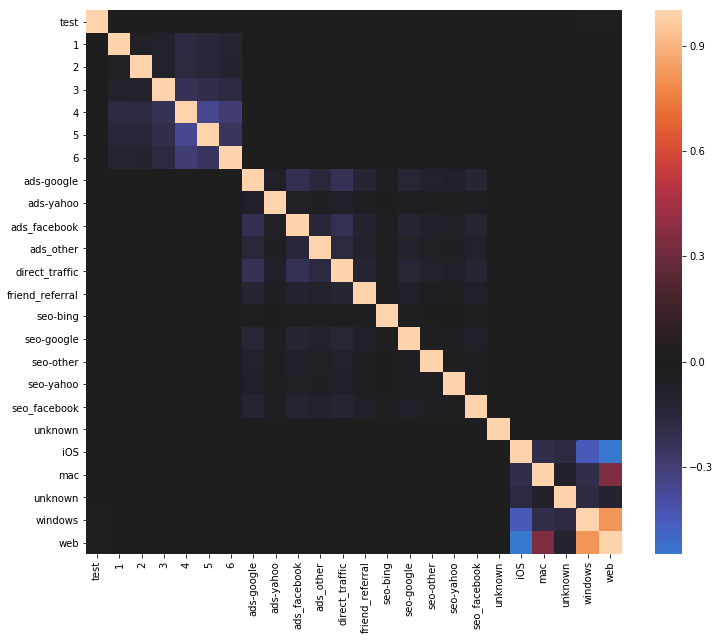

In [112]:
# correlation for all dummies in the dataframe

# there's an argument to change weekday to weekend vs weekday only dummy
# device might be redundant with mobile/desktop 

rcParams['figure.figsize'] = 12,10
sns.heatmap(fitdf.corr(), center = 0)  


In [199]:
# set up linear model

In [125]:
fitdf = sm.add_constant(fitdf)

In [126]:
model = sm.OLS(y, fitdf)

In [127]:
results = model.fit()

In [128]:
results.params

const              0.009603
test              -0.004255
1                 -0.001426
2                  0.000169
3                  0.000526
4                  0.000712
5                  0.000291
6                  0.001035
ads-google         0.009617
ads-yahoo          0.002706
ads_facebook       0.009366
ads_other          0.002727
direct_traffic     0.000484
friend_referral    0.026270
seo-bing           0.009138
seo-google         0.005085
seo-other          0.004241
seo-yahoo          0.004772
seo_facebook       0.004016
unknown           -0.008282
iOS                0.007262
mac                0.013454
unknown           -0.002424
windows            0.006290
web               -0.004371
dtype: float64

In [129]:
results.tvalues

const               6.492347
test               -7.961936
1                  -0.974489
2                   0.114055
3                   0.409525
4                   0.621747
5                   0.249455
6                   0.856952
ads-google          8.557175
ads-yahoo           1.412652
ads_facebook        8.206107
ads_other           2.150695
direct_traffic      0.431495
friend_referral    18.970699
seo-bing            2.813027
seo-google          3.778618
seo-other           2.385199
seo-yahoo           2.402522
seo_facebook        2.918752
unknown            -1.008060
iOS                10.316325
mac                 4.995773
unknown            -1.934668
windows             2.443267
web                -1.763419
dtype: float64

In [140]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     38.02
Date:                Thu, 25 Oct 2018   Prob (F-statistic):          6.63e-177
Time:                        23:17:15   Log-Likelihood:             1.6137e+05
No. Observations:              271609   AIC:                        -3.227e+05
Df Residuals:                  271584   BIC:                        -3.224e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0096      0.001      6.492      0.000       0.007       0.013
test               -0.0043      0.001     -7.962      0.000      -0.005      -0.003
1                  -0.0014      0.001     -0.974      0.330      -0.004       0.001
2                   0.0002      0.001      0.114      0.909      -0.003       0.003
3                   0.0005      0.001      0.410      0.682      -0.002       0.003
4                   0.0007      0.001      0.622      0.534      -0.002       0.003
5                   0.0003      0.001      0.249      0.803      -0.002       0.003
6                   0.0010      0.001      0.857      0.391      -0.001       0.003
ads-google          0.0096      0.001      8.557      0.000       0.007       0.012
ads-yahoo           0.0027      0.002      1.413      0.158      -0.001       0.006
ads_facebook        0.0094      0.001      8.206      0.000       0.007       0.012
ads_other           0.0027      0.001      2.151      0.032       0.000       0.005
direct_traffic      0.0005      0.001      0.431      0.666      -0.002       0.003
friend_referral     0.0263      0.001     18.971      0.000       0.024       0.029
seo-bing            0.0091      0.003      2.813      0.005       0.003       0.016
seo-google          0.0051      0.001      3.779      0.000       0.002       0.008
seo-other           0.0042      0.002      2.385      0.017       0.001       0.008
seo-yahoo           0.0048      0.002      2.403      0.016       0.001       0.009
seo_facebook        0.0040      0.001      2.919      0.004       0.001       0.007
unknown            -0.0083      0.008     -1.008      0.313      -0.024       0.008
iOS                 0.0073      0.001     10.316      0.000       0.006       0.009
mac                 0.0135      0.003      4.996      0.000       0.008       0.019
unknown            -0.0024      0.001     -1.935      0.053      -0.005    3.17e-05
windows             0.0063      0.003      2.443      0.015       0.001       0.011
web                -0.0044      0.002     -1.763      0.078      -0.009       0.000
==============================================================================
Omnibus:                   337815.212   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         30084586.173
Skew:                           7.165   Prob(JB):                         0.00
Kurtosis:                      52.528   Cond. No.                         44.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [200]:
# Try fitting a logit?

In [142]:
model = sm.Logit(y, fitdf)

In [143]:
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.089541
         Iterations 10


In [144]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               271609
Model:                          Logit   Df Residuals:                   271584
Method:                           MLE   Df Model:                           24
Date:                Thu, 25 Oct 2018   Pseudo R-squ.:                 0.01702
Time:                        23:23:09   Log-Likelihood:                -24320.
converged:                       True   LL-Null:                       -24741.
                                        LLR p-value:                2.368e-162
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.5743      0.093    -49.189      0.000      -4.757      -4.392
test               -0.2473      0.031     -7.930      0.000      -0.308      -0.186
1                  -0.0841      0.085     -0.992      0.321      -0.250       0.082
2                   0.0109      0.084      0.129      0.897      -0.154       0.175
3                   0.0290      0.072      0.400      0.689      -0.113       0.171
4                   0.0407      0.065      0.628      0.530      -0.086       0.168
5                   0.0168      0.066      0.254      0.799      -0.113       0.147
6                   0.0583      0.068      0.855      0.392      -0.075       0.192
ads-google          0.6061      0.073      8.306      0.000       0.463       0.749
ads-yahoo           0.2097      0.123      1.702      0.089      -0.032       0.451
ads_facebook        0.5940      0.074      8.053      0.000       0.449       0.739
ads_other           0.2112      0.084      2.505      0.012       0.046       0.376
direct_traffic      0.0402      0.077      0.521      0.603      -0.111       0.192
friend_referral     1.1984      0.077     15.568      0.000       1.047       1.349
seo-bing            0.5813      0.175      3.323      0.001       0.238       0.924
seo-google          0.3644      0.086      4.232      0.000       0.196       0.533
seo-other           0.3113      0.111      2.796      0.005       0.093       0.529
seo-yahoo           0.3436      0.122      2.817      0.005       0.105       0.583
seo_facebook        0.2967      0.089      3.329      0.001       0.122       0.471
unknown            -1.1715      1.004     -1.167      0.243      -3.140       0.797
iOS                 0.4045      0.040     10.038      0.000       0.326       0.483
mac                 0.8901      0.204      4.364      0.000       0.490       1.290
unknown            -0.1840      0.084     -2.194      0.028      -0.348      -0.020
windows             0.5290      0.201      2.634      0.008       0.135       0.923
web                -0.4057      0.196     -2.066      0.039      -0.791      -0.021
===================================================================================
"""

In [201]:
# Weighted least squares to account for class imbalance between treat/test groups
# give it approximate 2:1 weight by adjusting test variable

In [161]:
logmodel=sm.WLS(y, fitdf, weights=fitdf['test'] + 1, 
                family=sm.families.Binomial(sm.families.links.logit)).fit()


In [162]:
logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.003
Model:                            WLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     38.10
Date:                Thu, 25 Oct 2018   Prob (F-statistic):          2.79e-177
Time:                        23:50:14   Log-Likelihood:             1.5897e+05
No. Observations:              271609   AIC:                        -3.179e+05
Df Residuals:                  271584   BIC:                        -3.176e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0095      0.001      6.483      0.000       0.007       0.012
test               -0.0042      0.001     -8.403      0.000      -0.005      -0.003
1                  -0.0012      0.001     -0.804      0.421      -0.004       0.002
2               -3.262e-05      0.001     -0.023      0.982      -0.003       0.003
3                   0.0009      0.001      0.731      0.465      -0.002       0.003
4                   0.0012      0.001      1.097      0.273      -0.001       0.003
5                   0.0011      0.001      0.963      0.336      -0.001       0.003
6                   0.0011      0.001      0.913      0.361      -0.001       0.003
ads-google          0.0097      0.001      8.853      0.000       0.008       0.012
ads-yahoo           0.0029      0.002      1.523      0.128      -0.001       0.007
ads_facebook        0.0089      0.001      7.937      0.000       0.007       0.011
ads_other           0.0030      0.001      2.410      0.016       0.001       0.005
direct_traffic      0.0005      0.001      0.445      0.656      -0.002       0.003
friend_referral     0.0253      0.001     18.678      0.000       0.023       0.028
seo-bing            0.0071      0.003      2.255      0.024       0.001       0.013
seo-google          0.0054      0.001      4.089      0.000       0.003       0.008
seo-other           0.0039      0.002      2.263      0.024       0.001       0.007
seo-yahoo           0.0040      0.002      2.030      0.042       0.000       0.008
seo_facebook        0.0041      0.001      3.053      0.002       0.001       0.007
unknown            -0.0059      0.008     -0.733      0.464      -0.022       0.010
iOS                 0.0072      0.001     10.441      0.000       0.006       0.009
mac                 0.0153      0.003      5.942      0.000       0.010       0.020
unknown            -0.0023      0.001     -1.896      0.058      -0.005    7.86e-05
windows             0.0085      0.002      3.445      0.001       0.004       0.013
web                -0.0068      0.002     -2.893      0.004      -0.011      -0.002
==============================================================================
Omnibus:                   348926.604   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         38436245.975
Skew:                           7.503   Prob(JB):                         0.00
Kurtosis:                      59.313   Cond. No.                         46.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Run a power calculation: how many N did I really need to show my difference in means was significant? (Based on the magnitude of effect I found this time). 

In [165]:
len(newdf[newdf['test'] == 1])

97683

In [166]:
len(newdf)

271609

In [178]:
# variance of the sample mean
from statistics import stdev
sigmasq = stdev(newdf.converted)**2
sigmasq

0.017903295254870392

In [179]:
# difference in the sample means from treatment and control I just got
# cumulative conversion rates
diffofmeans = .021-0.015
diffofmeans

0.006000000000000002

In [182]:
# If I want to be able to put 2 std deviations between my sample means:

In [183]:
n = sigmasq/(diffofmeans/2)**2

In [184]:
# number of treated units I need to ensure I can measure a significant difference between sample means
# I only needed about 2000 points (in test group). I had 100000. I had 50 times what I needed.
n

1989.2550283189312

In [186]:
len(newdf[newdf['test']==1])

97683

## What does my t stat look like on today's difference of means? 

In [192]:
s0 = stdev(newdf[newdf['test']==0]['converted']**2)
s1 = stdev(newdf[newdf['test']==1]['converted']**2)
n0 = len(newdf[newdf['test']==0])
n1 = len(newdf[newdf['test']==1])

In [193]:
t = diffofmeans/sqrt((s0/n0)+(s1/n1))

In [194]:
t

4.176210642981103

In [204]:
# Yep. Those means are different. 